In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [2]:
IMAGE_SIZE = 256;
BATCH_SIZE = 32;
CHANNELS = 3; # RGB channels
EPOCHS = 5    # To build model on 5 epochs 

In [3]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 2 1 1 2 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 2]


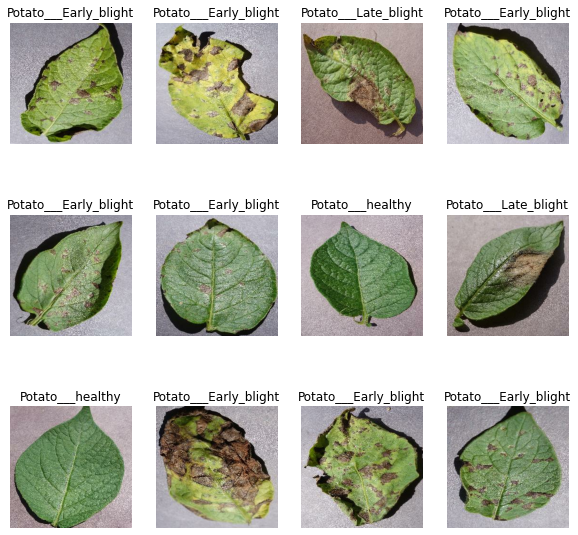

In [8]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

80% ==> training

20% ==> 10% validation, 10% test

In [10]:
# We need to count how many dataset being needed to use in dataset.take()
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [20]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [21]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [22]:
val_ds= test_ds.take(6)

In [23]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [28]:
def  get_dataset_partitions_tf(ds, train_split= 0.8,val_split= 0.1, test_split = 0.1,shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size) 
    return train_ds, val_ds, test_ds 

In [30]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [31]:
len(train_ds)

54

In [32]:
len(val_ds)

6

In [33]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [34]:
resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [36]:
data_agumentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [42]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 conv2d_10 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (32, 60, 60, 64)         

In [44]:
model.compile(
optimizer = 'adam',
loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
metrics = ['accuracy'])

In [46]:
history = model.fit(
train_ds,
epochs = EPOCHS,
batch_size = BATCH_SIZE,
verbose =1,
validation_data = val_ds)

Epoch 1/5
54/54 [==============================] - 99s 2s/step - loss: 0.9243 - accuracy: 0.4861 - val_loss: 0.9065 - val_accuracy: 0.4048
Epoch 2/5
54/54 [==============================] - 86s 2s/step - loss: 0.7462 - accuracy: 0.6528 - val_loss: 0.5841 - val_accuracy: 0.7143
Epoch 3/5
54/54 [==============================] - 85s 2s/step - loss: 0.3976 - accuracy: 0.8293 - val_loss: 0.3659 - val_accuracy: 0.8631
Epoch 4/5
54/54 [==============================] - 85s 2s/step - loss: 0.3399 - accuracy: 0.8692 - val_loss: 0.2733 - val_accuracy: 0.9048
Epoch 5/5
54/54 [==============================] - 85s 2s/step - loss: 0.2776 - accuracy: 0.8883 - val_loss: 0.4299 - val_accuracy: 0.8393


In [47]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 403ms/step - loss: 0.4923 - accuracy: 0.7969


In [48]:
scores

[0.49232450127601624, 0.796875]

In [49]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
history.history['accuracy']

[0.4861111044883728,
 0.6527777910232544,
 0.8292824029922485,
 0.8692129850387573,
 0.8883101940155029]

In [53]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

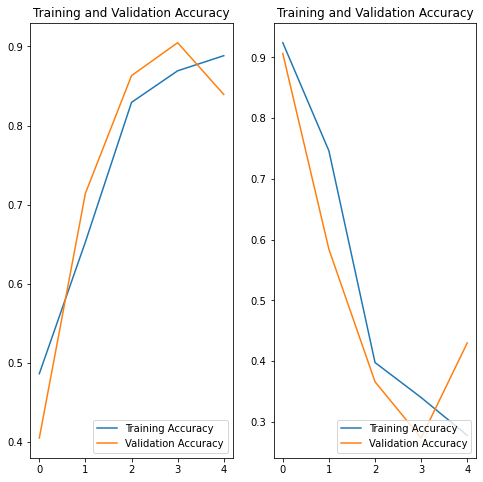

In [57]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

first_images to predict
Actual label: Potato___healthy
Predicted label: Potato___healthy


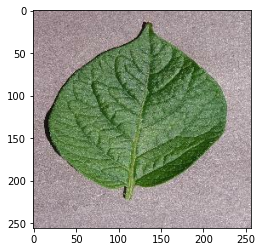

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first_images to predict')
    plt.imshow(first_image)
    print('Actual label:',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('Predicted label:',class_names[np.argmax(batch_prediction[0])])

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

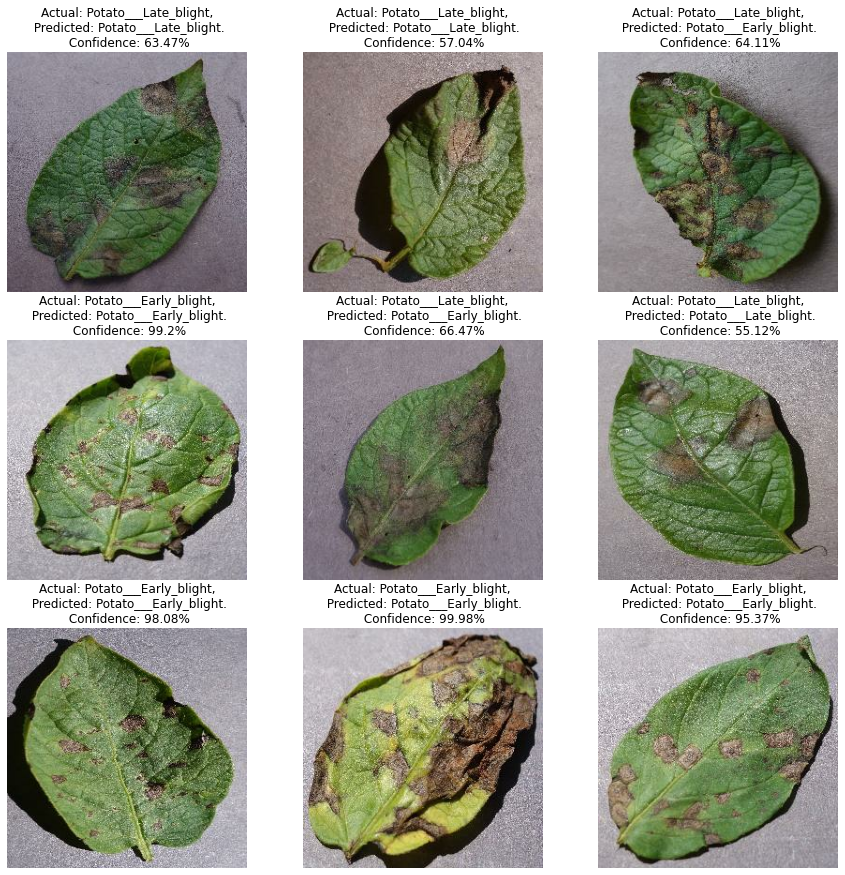

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [62]:
import os
[int(i) for i in os.listdir('../models')]

[1]

In [61]:
model_version= 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
